In [12]:
import pandas as pd
import glob

# Load all the parquet files into a single DataFrame
data_files = glob.glob("market=SOL_USDC/*/l1.parquet")
df_list = [pd.read_parquet(file) for file in data_files]

# Concatenate all data into one DataFrame
df = pd.concat(df_list, ignore_index=True)

# Convert timestamp to datetime
df['ts_utc'] = pd.to_datetime(df['ts_utc'])
df.set_index('ts_utc', inplace=True)

# Optional: Sort by timestamp
df = df.sort_index()

# Show the first few rows to verify
# print(df.head())

print(f"total ticks: {len(df)}")


total ticks: 92600


In [2]:
# Calculate returns (price change percentage)
df['return'] = df['ask_px'].pct_change()

# Calculate bid-ask spread in basis points
df['spread_bps'] = ((df['ask_px'] - df['bid_px']) / df['ask_px']) * 10000

# Calculate order imbalance (ratio of bid/ask sizes)
df['order_imbalance'] = df['bid_sz'] / df['ask_sz']

# Calculate volatility (rolling window of standard deviation of returns)
df['volatility'] = df['return'].rolling(window=60).std()

# Calculate moving average of price (for smoothing)
df['ma_ask'] = df['ask_px'].rolling(window=60).mean()

df['ema_ask'] = df['ask_px'].ewm(span=60, adjust=False).mean()

# Bollinger Bands: Calculate the upper and lower Bollinger bands based on standard deviation of price.
rolling_mean = df['ask_px'].rolling(window=20).mean()
rolling_std = df['ask_px'].rolling(window=20).std()
df['bb_upper'] = rolling_mean + (rolling_std * 2)
df['bb_lower'] = rolling_mean - (rolling_std * 2)

# Relative Strength Index (RSI): A momentum oscillator that measures the speed and change of price movements.

delta = df['ask_px'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
RS = gain / loss
df['RSI'] = 100 - (100 / (1 + RS))

# MACD
ema_12 = df['ask_px'].ewm(span=12, adjust=False).mean()
ema_26 = df['ask_px'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26

df.head()

,slot,bid_px,bid_sz,ask_px,ask_sz,spread_bps,source,raw_hash,return,order_imbalance,volatility,ma_ask,ema_ask,bb_upper,bb_lower,RSI,MACD
ts_utc,,,,,,,,,,,,,,,,,
2025-05-26 15:25:06.025137+00:00,342610908,177.37,68.048,177.38,485.193,0.563761,binance,cee24be1987f92d7,NaN,0.140249,NaN,NaN,177.380000,NaN,NaN,NaN,0.000000
2025-05-26 15:25:16.793269+00:00,342610935,177.38,74.453,177.39,165.921,0.563730,binance,a962de6cedc37c07,0.000056,0.448726,NaN,NaN,177.380328,NaN,NaN,NaN,0.000798
2025-05-26 15:25:27.511247+00:00,342610963,177.36,342.716,177.37,110.838,0.563793,binance,d362a0efb1edc93c,-0.000113,3.092044,NaN,NaN,177.379989,NaN,NaN,NaN,-0.000182
2025-05-26 15:25:38.335590+00:00,342610991,177.44,346.942,177.45,68.763,0.563539,binance,8da6b026e950eca1,0.000451,5.045475,NaN,NaN,177.382285,NaN,NaN,NaN,0.005435
2025-05-26 15:25:49.296684+00:00,342611020,177.51,140.318,177.52,109.870,0.563317,binance,86f4a801dd6335a5,0.000394,1.277128,NaN,NaN,177.386800,NaN,NaN,NaN,0.015357


In [3]:
# Define momentum using previous returns
df['momentum'] = df['return'].rolling(window=5).sum()

# Alpha: Positive momentum indicates a long signal, negative momentum indicates a short signal
df['alpha_momentum'] = df['momentum'].apply(lambda x: 1 if x > 0 else -1)


In [4]:
# Define mean-reversion signal
df['mean_reversion'] = df['ask_px'] - df['ma_ask']

# Alpha: Large deviation from mean suggests potential reversion
df['alpha_mean_reversion'] = df['mean_reversion'].apply(lambda x: 1 if x > 0 else -1)

In [5]:
# Vectorized spread alpha calculation
import numpy as np
threshold = df['spread_bps'].quantile(0.75)
df['alpha_spread'] = np.where(df['spread_bps'] > threshold, 1, -1)

# Vectorized order imbalance calculation
df['alpha_imbalance'] = np.where(df['order_imbalance'] > 1, 1, -1)

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier

# Assuming df has already been processed and features are generated

# Calculate the target variable (next tick return)
target = (df['return'].shift(-1) > 0).astype(int)

# Drop the last row in the dataframe since the target for that row will be NaN
df.dropna(subset=['return'], inplace=True)
target = target.loc[df.index]  # Ensure target aligns with the dataframe after dropping NaN rows

# Define features for the model
features = ['momentum', 'mean_reversion', 'spread_bps', 'order_imbalance',
            'ema_ask', 'bb_upper', 'bb_lower', 'RSI', 'MACD']

# Ensure no missing values in features
df.dropna(subset=features, inplace=True)

# Train/test split
X = df[features]
y = target.loc[df.index]  # Align target with df after dropping rows
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train XGBoost model
model = XGBClassifier(n_estimators=100, learning_rate=0.01, max_depth=3, colsample_bytree=1.0, subsample=0.8)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))


Model accuracy: 0.67
              precision    recall  f1-score   support

           0       0.67      0.96      0.79     11992
           1       0.62      0.13      0.22      6512

    accuracy                           0.67     18504
   macro avg       0.65      0.54      0.50     18504
weighted avg       0.65      0.67      0.59     18504



In [7]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

grid_search = GridSearchCV(XGBClassifier(), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)
print(f"Best hyperparameters: {grid_search.best_params_}")

Best hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


<Figure size 1000x600 with 0 Axes>

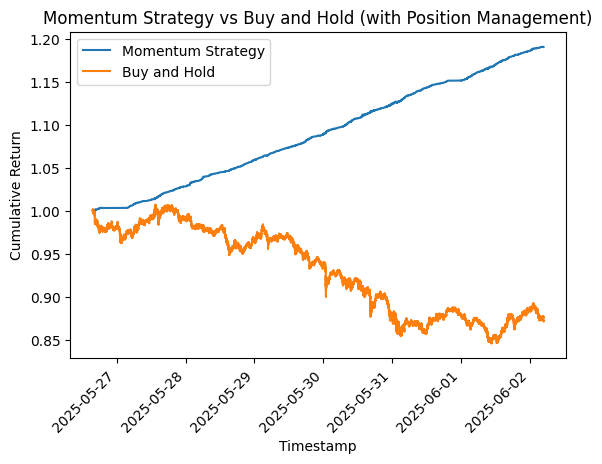

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = df.drop(columns=['predicted_prob', 'position_size', 'cumulative_exposure', 'position_size', 'momentum_position', 
                     'momentum_strategy_return', 'momentum_cum_return', 'buy_and_hold_position', 'buy_and_hold_return', 
                      'buy_and_hold_cum_return'], errors='ignore')

# Model prediction: get probabilities (momentum strength) from the trained model
df['predicted_prob'] = model.predict_proba(X)[:, 1]  # Get the predicted probability for the positive momentum class

# Define position management parameters
max_position_size = 0.8  # Maximum fraction of portfolio size per position (e.g., 5% per trade)
confidence_threshold = 0.5  # Confidence level threshold (e.g., only trade if predicted prob > 50%)
exposure_limit = 0.4  # Max total portfolio exposure at any given time (e.g., 30% of portfolio in active positions)

# Use predicted probability directly to scale the position size (smooth scaling)
df['position_size'] = df['predicted_prob'].apply(lambda x: max_position_size * x if x > confidence_threshold else 0)

# Track cumulative exposure without the deprecated warning:
df['cumulative_exposure'] = df['position_size'].cumsum()

# Momentum strategy position: scaling the position by confidence, long or short based on momentum direction
df['momentum_position'] = df['position_size'] \
                            * df['predicted_prob']

# Simulate returns: scaling returns based on position size (fractional leverage)
df['momentum_strategy_return'] = df['momentum_position'].shift(1) * df['return']

# Calculate cumulative returns for momentum strategy
df['momentum_cum_return'] = (1 + df['momentum_strategy_return']).cumprod()

# Define Buy-and-Hold strategy: always holding a fixed position (full exposure)
df['buy_and_hold_position'] = 1  # Full position at all times
df['buy_and_hold_return'] = df['buy_and_hold_position'].shift(1) * df['return']
df['buy_and_hold_cum_return'] = (1 + df['buy_and_hold_return']).cumprod()

# Plot results
plt.figure(figsize=(10, 6))
df[['momentum_cum_return', 'buy_and_hold_cum_return']].plot()
plt.title('Momentum Strategy vs Buy and Hold (with Position Management)')
plt.xlabel('Timestamp')
plt.ylabel('Cumulative Return')
plt.legend(['Momentum Strategy', 'Buy and Hold'])
plt.xticks(rotation=45)
plt.show()

<Figure size 1000x600 with 0 Axes>

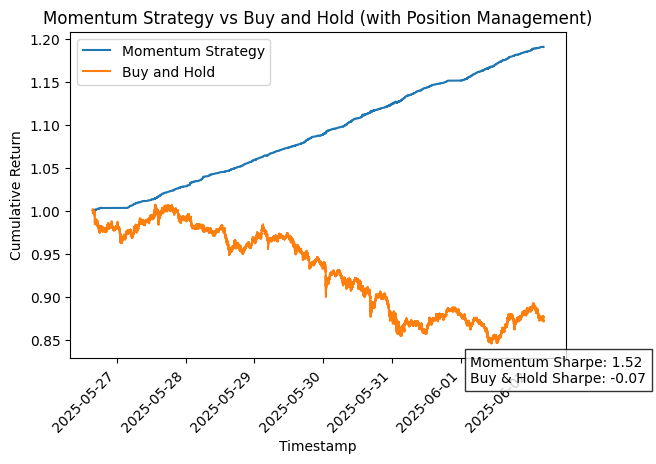

In [9]:

# Calculate Sharpe Ratios
def calculate_sharpe(returns, days_per_year=252):
    returns_tmp = returns.dropna()
    if len(returns_tmp) == 0 or returns_tmp.std() == 0:
        return 0
    return (returns_tmp.mean() / returns_tmp.std()) * (days_per_year**0.5)

momentum_sharpe = calculate_sharpe(df['momentum_strategy_return'])
bh_sharpe = calculate_sharpe(df['buy_and_hold_return'])

# Plot results
plt.figure(figsize=(10, 6))
df[['momentum_cum_return', 'buy_and_hold_cum_return']].plot()
plt.title('Momentum Strategy vs Buy and Hold (with Position Management)')
plt.xlabel('Timestamp')
plt.ylabel('Cumulative Return')
plt.legend(['Momentum Strategy', 'Buy and Hold'])

# Add Sharpe Ratio annotation
textstr = '\n'.join((
    f'Momentum Sharpe: {momentum_sharpe:.2f}',
    f'Buy & Hold Sharpe: {bh_sharpe:.2f}'
))

plt.figtext(0.75, 0.15, textstr, 
            bbox=dict(facecolor='white', alpha=0.8),
            fontsize=10)

plt.xticks(rotation=45)
plt.show()

In [10]:
df.to_parquet("./simple_alpha.parquet")

In [11]:
df

,slot,bid_px,bid_sz,ask_px,ask_sz,spread_bps,source,raw_hash,return,order_imbalance,...,alpha_imbalance,predicted_prob,position_size,cumulative_exposure,momentum_position,momentum_strategy_return,momentum_cum_return,buy_and_hold_position,buy_and_hold_return,buy_and_hold_cum_return
ts_utc,,,,,,,,,,,,,,,,,,,,,
2025-05-26 15:35:49.874797+00:00,342612548,178.12,179.802,178.13,85.623,0.561388,binance,e10ccec0f7544898,-0.001009,2.099926,...,1,0.413810,0.000000,0.000000,0.000000,NaN,NaN,1,NaN,NaN
2025-05-26 15:36:00.755868+00:00,342612574,178.12,578.821,178.13,0.506,0.561388,binance,b5544d77002e9f62,0.000000,1143.915020,...,1,0.547479,0.437983,0.437983,0.239787,0.000000,1.000000,1,0.000000,1.000000
2025-05-26 15:36:11.363319+00:00,342612601,178.16,374.805,178.17,25.666,0.561262,binance,7a0a7df7178babc3,0.000225,14.603172,...,1,0.498959,0.000000,0.437983,0.000000,0.000054,1.000054,1,0.000225,1.000225
2025-05-26 15:36:21.957801+00:00,342612626,178.15,84.875,178.16,288.320,0.561293,binance,74194bb2ee2ccbc0,-0.000056,0.294378,...,-1,0.302603,0.000000,0.437983,0.000000,-0.000000,1.000054,1,-0.000056,1.000168
2025-05-26 15:36:32.544089+00:00,342612653,178.03,147.671,178.04,87.600,0.561672,binance,3c8b07bf87850f9c,-0.000674,1.685742,...,1,0.384884,0.000000,0.437983,0.000000,-0.000000,1.000054,1,-0.000674,0.999495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-02 04:54:41.970114+00:00,344051564,155.15,175.315,155.16,148.613,0.644496,binance,783fd951001b8d3e,0.000064,1.179675,...,1,0.432420,0.000000,2862.007569,0.000000,0.000000,1.190475,1,0.000064,0.871049
2025-06-02 04:54:47.479985+00:00,344051579,155.17,302.169,155.18,111.728,0.644413,binance,137902f0ae03d88e,0.000129,2.704506,...,1,0.429550,0.000000,2862.007569,0.000000,0.000000,1.190475,1,0.000129,0.871162
2025-06-02 04:54:52.990487+00:00,344051593,155.17,121.793,155.18,165.206,0.644413,binance,fc7485438075d00f,0.000000,0.737219,...,-1,0.402182,0.000000,2862.007569,0.000000,0.000000,1.190475,1,0.000000,0.871162
